# II_tmatcher

purpose: template matching / drift correction script for time-lapse microscopy experiments using phase contract, FP segmentation marker and FP reporter channels

author: Camillo Moschner

email: cm967@cam.ac.uk

dates: start date- 15.03.2021; last updated- 22.10.2022

## Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from pandas import DataFrame
import os 

In [2]:
from pystackreg import StackReg
from skimage.transform import rotate, warp
from glob import glob
from pprint import pprint

from PIL import Image
from tqdm.notebook import tqdm
import multiprocessing
from joblib import Parallel, delayed

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from tifffile import TiffFile
from tifffile import memmap, imread
import napari

ModuleNotFoundError: No module named 'pystackreg'

In [ ]:
from image_analysis_helper import *

## CM's custom cmaps


In [ ]:
# special colourmaps
YFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","yellow"])
CFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","cyan"])
RFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
GFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","lime"])
BFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","dodgerblue"])

## Function Definitions
Import functions that you use in multiple scripts in the image_analysis_helper.py file while defining special functions that you only use in one script inside that script. 

If you want to loop through every FOV and then parallelise the processing of all timepoints in that FOV use "parallel_match_timepoints_in_FOV":

In [4]:
def parallel_match_timepoints_in_FOV(iterator, FOV_ims_info_df, channel_ids, y_window, x_window, save_to_folder, ims_rotation_angle=0):
    """
    1- Takes a single phase contrast image and calculates transformation matrix compared to reference phase contrast image
    2- applies transformation matrix to the corresponding (same time point) (1) phase contrast, (2) segmentation marker and (3) reporter image
    3- crops all three images
    4- saves all three images in newly created subfolder
    """
    PC_ims_info = FOV_ims_info_df.loc[FOV_ims_info_df['colour_channel']==channel_ids['phase_contrast_id']] # Phase Contrast
    sgm_marker_ims_info = FOV_ims_info_df.loc[FOV_ims_info_df['colour_channel']==channel_ids['segmentation_marker_id']] # Segmentation Marker
    reporter_ims_info = FOV_ims_info_df.loc[FOV_ims_info_df['colour_channel']==channel_ids['reporter_id']] # Reporter Gene
     # Choose reference image
    reference_phase_contrast = np.array(Image.open(PC_ims_info['directory'].iloc[4])) # <------ change reference position here!!!
    # Choose what type of image distortion PyStackReg should perform:
    sr = StackReg(StackReg.RIGID_BODY)
    # open the timepoint images as np.arrays:
    opened_phase_contrast_image_to_be_matched = np.array(Image.open(PC_ims_info['directory'].iloc[iterator]))
    opened_segm_marker_to_be_matched = np.array(Image.open(sgm_marker_ims_info['directory'].iloc[iterator]))
    opened_reporter_to_be_matched = np.array(Image.open(reporter_ims_info['directory'].iloc[iterator]))
    # 1- register the transition matrix that results from comparing the reference PC image array with the phase contrast array of that time point:
    transformation_matrix = sr.register(reference_phase_contrast, opened_phase_contrast_image_to_be_matched)
    # 2- perform transformations on each channel image array of that time point:
    registered_phase_contrast = warp(opened_phase_contrast_image_to_be_matched, transformation_matrix, preserve_range=True, order=3)  #sr.transform(opened_phase_contrast_image_to_be_matched)
    registered_mCherry = warp(opened_segm_marker_to_be_matched, transformation_matrix, preserve_range=True, order=3)  # sr.transform(opened_segm_marker_to_be_matched)
    registered_YFP = warp(opened_reporter_to_be_matched, transformation_matrix, preserve_range=True, order=3)  # sr.transform(opened_reporter_to_be_matched)
    # 3- rotate image (if wanted only):
    if ims_rotation_angle != 0:
        registered_phase_contrast = rotate(registered_phase_contrast, ims_rotation_angle)
        registered_mCherry = rotate(registered_mCherry, ims_rotation_angle)
        registered_YFP = rotate(registered_YFP, ims_rotation_angle)
    # 4- rough crop:
    registered_phase_contrast = registered_phase_contrast[y_window,x_window]
    registered_mCherry = registered_mCherry[y_window,x_window]
    registered_YFP = registered_YFP[y_window,x_window]
    # 5- convert each transformed image array back to an image and finally save the matched image to a new folder:
    im = Image.fromarray(registered_phase_contrast.astype(np.uint16))
    im.save(save_to_folder+'/'+PC_ims_info['directory'].iloc[iterator].split('/')[-1])
    im = Image.fromarray(registered_mCherry.astype(np.uint16))
    im.save(save_to_folder+'/'+sgm_marker_ims_info['directory'].iloc[iterator].split('/')[-1])
    im = Image.fromarray(registered_YFP.astype(np.uint16))
    im.save(save_to_folder+'/'+reporter_ims_info['directory'].iloc[iterator].split('/')[-1])
    return None

If you want to parallel process all FOVs simultaneously, i.e. all timepoints are processed consecutively for each FOV but all FOVs are prcessed in parallel use "match_all_ims_in_FOV" -> go to 4.01. Parallelise FOV

In [5]:
def match_all_ims_in_FOV(FOV, ims_info_df, channel_ids, y_window, x_window, save_to_folder, ims_rotation_angle=0):
    """
    1- Takes phase contrast images and calculates transformation matrix compared to reference phase contrast image
    2- applies transformation matrix to the corresponding (same time point) (1) phase contrast, (2) segmentation marker and (3) reporter image
    3- crops all three images
    4- saves all three images in newly created subfolder
    """
    ims_info_df = ims_info_df.loc[image_info['FOV']==FOV]
    PC_ims_info = ims_info_df.loc[ims_info_df['colour_channel']==channel_ids['phase_contrast_id']] # Phase Contrast
    sgm_marker_ims_info = ims_info_df.loc[ims_info_df['colour_channel']==channel_ids['segmentation_marker_id']] # Segmentation Marker
    reporter_ims_info = ims_info_df.loc[ims_info_df['colour_channel']==channel_ids['reporter_id']] # Reporter Gene
    # Choose reference image
    reference_phase_contrast = np.array(Image.open(PC_ims_info['directory'].iloc[99])) # <------ change reference position here!!!
    # Choose what type of image distortion PyStackReg should perform:
    sr = StackReg(StackReg.RIGID_BODY)
    # Loop through each timepoint and perform template matching:
    for x in tqdm(range(0,PC_ims_info.shape[0])):
        # open the timepoint images as np.arrays:
        opened_phase_contrast_image_to_be_matched = np.array(Image.open(PC_ims_info['directory'].iloc[x]))
        opened_segm_marker_to_be_matched = np.array(Image.open(sgm_marker_ims_info['directory'].iloc[x]))
        opened_reporter_to_be_matched = np.array(Image.open(reporter_ims_info['directory'].iloc[x]))
        # 1- register the transition matrix that results from comparing the reference PC image array with the phase contrast array of that time point:
        transformation_matrix = sr.register(reference_phase_contrast, opened_phase_contrast_image_to_be_matched)
        # 2- perform transformations on each channel image array of that time point:
        registered_phase_contrast = warp(opened_phase_contrast_image_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_phase_contrast_image_to_be_matched)
        registered_mCherry = warp(opened_segm_marker_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_segm_marker_to_be_matched)
        registered_YFP = warp(opened_reporter_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_reporter_to_be_matched)
        # 3- rotate image (if wanted only):
        if ims_rotation_angle != 0:
            registered_phase_contrast = rotate(registered_phase_contrast, ims_rotation_angle)
            registered_mCherry = rotate(registered_mCherry, ims_rotation_angle)
            registered_YFP = rotate(registered_YFP, ims_rotation_angle)
        # 4- rough crop:
        registered_phase_contrast = registered_phase_contrast[y_window,x_window]
        registered_mCherry = registered_mCherry[y_window,x_window]
        registered_YFP = registered_YFP[y_window,x_window]
        # 5- convert each transformed image array back to an image and finally save the matched image to a new folder:
        im = Image.fromarray(registered_phase_contrast.astype(np.uint16))
        im.save(save_to_folder+'/'+PC_ims_info['directory'].iloc[x].split('/')[-1])
        im = Image.fromarray(registered_mCherry.astype(np.uint16))
        im.save(save_to_folder+'/'+sgm_marker_ims_info['directory'].iloc[x].split('/')[-1])
        im = Image.fromarray(registered_YFP.astype(np.uint16))
        im.save(save_to_folder+'/'+reporter_ims_info['directory'].iloc[x].split('/')[-1])
    return print("FOV {:} processed.".format(FOV))

-----
# Define Data Information
Raw image directory:

In [6]:
ims_directory = "/1_extracted_pngs/"

Image format:

In [7]:
ims_format = 'png' # either 'png' or 'tif'

Save-to-folder:

In [8]:
save_to_folder= "/2_registered_pngs/"
if save_to_folder[-1] != "/":
    save_to_folder += "/"

Define colour channel names:

In [9]:
PC_id = 'PC'
segm_marker_id = 'mCherry'
reporter_id = 'Green'
channel_ids = {'phase_contrast_id':PC_id, 
               'segmentation_marker_id':segm_marker_id, 
               'reporter_id':reporter_id}

- - - - - - 

# Data Exploration & Preparation
Load all

In [10]:
image_info = source_image_info(ims_directory,ims_format)

In [11]:
image_info#['colour_channel'].unique()

,directory
0,/Users/camillomoschner/Desktop/Screenshot 2022...
1,/Users/camillomoschner/Desktop/Screenshot 2022...
2,/Users/camillomoschner/Desktop/Screenshot 2022...
3,/Users/camillomoschner/Desktop/Screenshot 2022...
4,/Users/camillomoschner/Desktop/Screenshot 2022...
5,/Users/camillomoschner/Desktop/Screenshot 2022...
6,/Users/camillomoschner/Desktop/xy000_T0000_PC_...
7,/Users/camillomoschner/Desktop/Screenshot 2022...
8,/Users/camillomoschner/Desktop/Screenshot 2022...
9,/Users/camillomoschner/Desktop/xy000_T0000_PC_...


Quickly check that you've defined the correct colour channels (easily done with set operations 'intersection' and 'symmetric_difference'):

In [12]:
id_intersection = set(channel_ids.values()) & set(image_info['colour_channel'].unique())
is_symmetric_difference = set(channel_ids.values()) ^ set(image_info['colour_channel'].unique())
print("Colour channels \n",id_intersection, "\nare found in both the info DataFrame and the user-given input.")
if len(is_symmetric_difference) != 0:
    print("WARNING: Colour channels",is_symmetric_difference, "are not members of both colour channel sets. You need to check what happened.")

KeyError: 'colour_channel'

## Identify your FOVs:

In [13]:
FOV_list = list(image_info['FOV'].unique())
print("Number of FOV in your dataset after manual deletion:",len(FOV_list),'\n')
print(FOV_list)

KeyError: 'FOV'

## Testing and Visualising 

In [14]:
FOV_name_test = 'xy000'
channel_test = 'PC'
test_df = image_info.loc[image_info['FOV']==FOV_name_test].loc[image_info['colour_channel']==channel_test]


Size =  (1400, 2304)


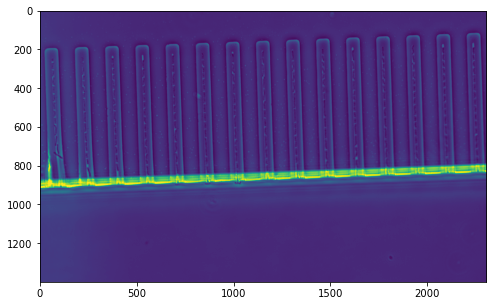

In [15]:
test_timepoint = 10
test_im_dir = test_df['directory'].iloc[test_timepoint]

test_im = convert_to_nparray(test_im_dir)#[500:1000,:]
plt.figure(figsize=(8,8))
imshow(test_im[:,:]);#,cmap='jet');
print("\nSize = ",test_im[:,:].shape)

In [16]:
convert_to_nparray(image_info['directory'].iloc[0]).shape

(1400, 2304)

In [30]:
image_info.loc[(image_info.FOV=='xy127') & (image_info.colour_channel=='PC')]

,directory,FOV,timepoint,colour_channel
38101,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,0,PC
38104,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,1,PC
38107,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,2,PC
38110,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,3,PC
38113,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,4,PC
...,...,...,...,...
38386,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,95,PC
38389,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,96,PC
38392,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,97,PC
38395,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,98,PC


In [17]:
@interact
def show_images(FOV = (0,len(FOV_list)-1),
                timepoints = (0,len(image_info['timepoint'].unique())-1),
                rotation_angle = (-5,5,0.1),
                y_win_top = (0,convert_to_nparray(image_info['directory'].iloc[0]).shape[0]-5),
                y_win_bottom = (0,convert_to_nparray(image_info['directory'].iloc[0]).shape[0]-1),
                x_win_left = (0,convert_to_nparray(image_info['directory'].iloc[0]).shape[1]-5),
                x_win_right = (0,convert_to_nparray(image_info['directory'].iloc[0]).shape[1]-1),):#,sigma=(0,25)
    FOV_name = FOV_list#['xy000', 'xy001', 'xy002', 'xy003', 'xy004', 'xy005', 'xy006', 'xy007', 'xy008', 'xy009', 'xy010', 'xy011', 'xy012']
    channel_name = ['Green','mCherry','PC']
    timepoint = image_info['timepoint'].unique()[timepoints]
    # metadata_df data:
    FOV_data = image_info[image_info['FOV']==FOV_name[FOV]]
    FOV_PC_data = FOV_data[FOV_data['colour_channel']=='PC']
    FOV_PC_channel_timepoint_data = FOV_PC_data[FOV_PC_data['timepoint']==timepoint]
    FOV_PC_timepoint_channel_im = convert_to_nparray(FOV_PC_channel_timepoint_data['directory'].iloc[0])
    plt.style.use('default')
    fig = plt.figure(figsize=(10,6),constrained_layout=True)
    gs = gridspec.GridSpec(1, 1, figure=fig)
    plt.suptitle(f"FOV: {FOV_name[FOV]} | timepoint: {timepoint}",size=14)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(rotate(FOV_PC_timepoint_channel_im[y_win_top:y_win_bottom, x_win_left:x_win_right],rotation_angle))#,cmap=GFP_cmap);
    ax1.set_xlabel(f"{FOV_PC_timepoint_channel_im.min()}-{FOV_PC_timepoint_channel_im.max()}")
    ax1.set_title(f" Green")
    global im_rotation_angle_global
    im_rotation_angle_global = rotation_angle
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=63, description='FOV', max=127), IntSlider(value=49, description='timepo…

In [18]:
# set rotation_angle fixed
im_rotation_angle = -2
y_window = slice(140,1140) # ident
x_window = slice(0,test_im.shape[1])

In [19]:
im_rotation_angle

-2

## Create Save Subfolder
Make new subfolder in current working directory to which you'll save the template matched images:

In [20]:
template_matched_folder = '1_tmatched_cropped'
try:
    os.mkdir(ims_directory+template_matched_folder)
except FileExistsError:
    print("Folder already exists")
save_to_folder_final = ims_directory+template_matched_folder
print('Matched images will be saved in new folder: \n',save_to_folder_final)

Folder already exists
Matched images will be saved in new folder: 
 /Users/camillomoschner/Desktop/221018_LVL2DVs_STMM/extracted/1_tmatched_cropped


# Execution
Loop through each FOV, extract list of phase contrast ims directories
choose a reference timpoint and with it a reference image

In [21]:
num_cores = multiprocessing.cpu_count()

## One FOV

In [23]:
save_to_folder = '/Users/camillomoschner/Desktop/221018_LVL2DVs_STMM/cm_registered_warp/'

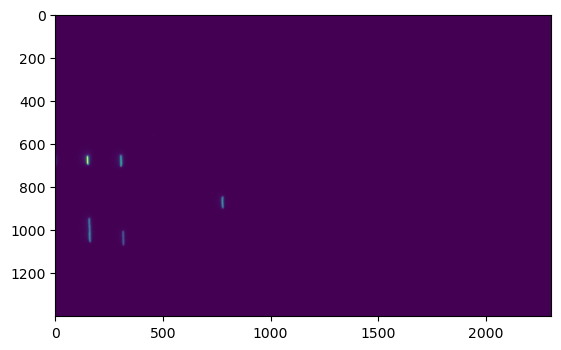

In [47]:
imshow(convert_to_nparray(FOV_ims_info_df_test.directory.iloc[0]))

In [22]:
pc = imread('/Users/camillomoschner/Desktop/xy03_PC.tif')
mcherry = imread('/Users/camillomoschner/Desktop/xy03_mCherry.tif')

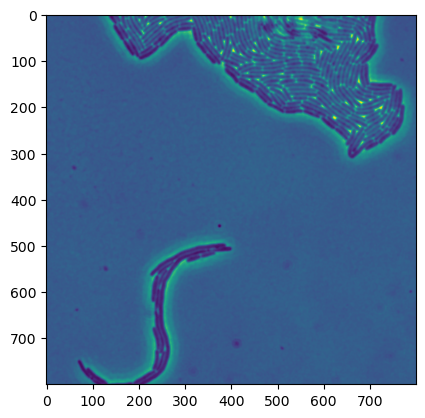

In [36]:
imshow(pc[20,750:1550,800:1600])

In [50]:
pc[x,:,:].shape
mean = mean_img

In [53]:
mean_img = np.zeros(pc[x,:,:].shape)
#mean_img_imgs = (self.get_image(FOV, channel, x, registered) for x in mean_times)
for x in tqdm(range(len(pc[:,:,:]))):
    mean_img += pc[x,:,:] #/ mean

  0%|          | 0/30 [00:00<?, ?it/s]

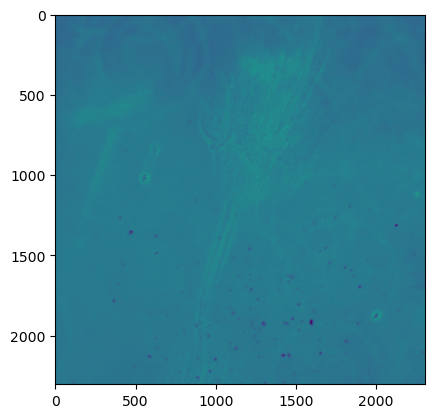

In [54]:
imshow(mean_img)

In [65]:
reversed(list(range(1,10)))

In [69]:
pc_list=[]
mcherry_list=[]


for x in tqdm(list(reversed(list(range(3,10))))):
    reference_phase_contrast = pc[x-3,:,:]#+pc[1,:,:] # <------ change reference position here!!!
    sr = StackReg(StackReg.RIGID_BODY)
    opened_phase_contrast_image_to_be_matched = pc[x,:,:]
    opened_segm_marker_to_be_matched = mcherry[x,:,:]
    # 1- register the transition matrix that results from comparing the reference PC image array with the phase contrast array of that time point:
    transformation_matrix = sr.register(reference_phase_contrast, opened_phase_contrast_image_to_be_matched)
    # 2- perform transformations on each channel image array of that time point:
    registered_phase_contrast = warp(opened_phase_contrast_image_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_phase_contrast_image_to_be_matched)
    #registered_mCherry = warp(opened_segm_marker_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_segm_marker_to_be_matched)
    
    pc_list.append(registered_phase_contrast)
    #mcherry_list.append(registered_mCherry)
    
    # 5- convert each transformed image array back to an image and finally save the matched image to a new folder:
#     im = Image.fromarray(registered_phase_contrast.astype(np.uint16))
#     im.save(save_to_folder+'/'+PC_ims_info['directory'].iloc[x].split('/')[-1])
#     im = Image.fromarray(registered_mCherry.astype(np.uint16))
#     im.save(save_to_folder+'/'+sgm_marker_ims_info['directory'].iloc[x].split('/')[-1])

  0%|          | 0/7 [00:00<?, ?it/s]

In [70]:
@interact
def show(x=(1,10)):
    imshow(pc_list[x])
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=5, description='x', max=10, min=1), Output()), _dom_classes=('widget-int…

In [ ]:
# Choose reference image
    # Choose what type of image distortion PyStackReg should perform:
    
    # Loop through each timepoint and perform template matching:
    for x in tqdm(range(0,PC_ims_info.shape[0])):
#         # open the timepoint images as np.arrays:
#         opened_phase_contrast_image_to_be_matched = np.array(Image.open(PC_ims_info['directory'].iloc[x]))
#         opened_segm_marker_to_be_matched = np.array(Image.open(sgm_marker_ims_info['directory'].iloc[x]))
        opened_reporter_to_be_matched = np.array(Image.open(reporter_ims_info['directory'].iloc[x]))
        # 1- register the transition matrix that results from comparing the reference PC image array with the phase contrast array of that time point:
        transformation_matrix = sr.register(reference_phase_contrast, opened_phase_contrast_image_to_be_matched)
        # 2- perform transformations on each channel image array of that time point:
        registered_phase_contrast = warp(opened_phase_contrast_image_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_phase_contrast_image_to_be_matched)
        registered_mCherry = warp(opened_segm_marker_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_segm_marker_to_be_matched)
        registered_YFP = warp(opened_reporter_to_be_matched, transformation_matrix, preserve_range=True, order=3) #sr.transform(opened_reporter_to_be_matched)
        # 3- rotate image (if wanted only):
        if ims_rotation_angle != 0:
            registered_phase_contrast = rotate(registered_phase_contrast, ims_rotation_angle)
            registered_mCherry = rotate(registered_mCherry, ims_rotation_angle)
            registered_YFP = rotate(registered_YFP, ims_rotation_angle)
        # 4- rough crop:
        registered_phase_contrast = registered_phase_contrast[y_window,x_window]
        registered_mCherry = registered_mCherry[y_window,x_window]
        registered_YFP = registered_YFP[y_window,x_window]
        # 5- convert each transformed image array back to an image and finally save the matched image to a new folder:
        im = Image.fromarray(registered_phase_contrast.astype(np.uint16))
        im.save(save_to_folder+'/'+PC_ims_info['directory'].iloc[x].split('/')[-1])
        im = Image.fromarray(registered_mCherry.astype(np.uint16))
        im.save(save_to_folder+'/'+sgm_marker_ims_info['directory'].iloc[x].split('/')[-1])
        im = Image.fromarray(registered_YFP.astype(np.uint16))
        im.save(save_to_folder+'/'+reporter_ims_info['directory'].iloc[x].split('/')[-1])
    return print("FOV {:} processed.".format(FOV))

In [52]:
#match_all_ims_in_FOV('xy001', image_info, channel_ids, y_window, x_window, save_to_folder, ims_rotation_angle=-2)
FOV_ims_info_df_test = image_info.loc[image_info['FOV']=='xy127']
FOV_timepoints_test = len(FOV_ims_info_df_test.loc[image_info['colour_channel']==channel_ids['segmentation_marker_id']])
print(FOV_name, '- {:} timepoints'.format(FOV_timepoints_test) )

if __name__ == "__main__":
    processed_images = Parallel(n_jobs=8)( delayed (parallel_match_timepoints_in_FOV) (iterator, FOV_ims_info_df_test, channel_ids, slice(450,1100), x_window, save_to_folder,ims_rotation_angle=-1.8)
                                             for iterator in tqdm(range(0,FOV_timepoints_test)) )

xy127 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

## All FOVs

### Parallelise FOVs

In [25]:
#if __name__ == "__main__":
 #   processed_images = Parallel(n_jobs=5)(delayed(match_all_ims_in_FOV)(FOV, image_info, channel_ids, y_window, x_window, save_to_folder)
  #                                               for FOV in tqdm(FOV_list))

### Parallelise timepoints in one FOV at a time
Requires standard for-loop through FOVs, creating FOV_DataFrames, handing these as inputs to the function:

In [26]:
for FOV_name in tqdm(FOV_list[:]):
    FOV_ims_info_df = image_info.loc[image_info['FOV']==FOV_name]
    FOV_timepoints = len(FOV_ims_info_df.loc[image_info['colour_channel']==channel_ids['segmentation_marker_id']])
    print(FOV_name, '- {:} timepoints'.format(FOV_timepoints) )
    
    if __name__ == "__main__":
        processed_images = Parallel(n_jobs=8)( delayed (parallel_match_timepoints_in_FOV) (iterator, FOV_ims_info_df, channel_ids, y_window, x_window, save_to_folder,ims_rotation_angle=im_rotation_angle)
                                                 for iterator in tqdm(range(0,FOV_timepoints)) )


  0%|          | 0/128 [00:00<?, ?it/s]

xy000 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy001 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy002 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/envs/ia-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


xy003 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy004 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy005 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy006 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy007 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy008 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy009 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy010 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy011 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy012 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy013 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy014 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy015 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy016 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy017 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy018 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy019 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy020 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy021 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy022 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy023 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy024 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy025 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy026 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy027 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy028 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy029 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy030 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy031 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy032 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy033 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy034 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy035 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy036 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy037 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy038 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy039 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy040 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy041 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy042 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy043 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy044 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy045 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy046 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy047 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy048 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy049 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy050 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy051 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy052 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy053 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy054 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy055 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy056 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy057 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy058 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy059 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy060 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy061 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy062 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy063 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy064 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy065 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy066 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy067 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy068 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy069 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy070 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy071 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy072 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy073 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy074 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy075 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy076 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy077 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy078 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy079 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy080 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy081 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy082 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy083 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy084 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy085 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy086 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy087 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy088 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy089 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy090 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy091 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy092 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy093 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy094 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy095 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy096 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy097 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy098 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy099 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy100 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy101 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy102 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy103 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy104 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy105 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy106 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy107 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy108 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy109 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy110 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy111 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy112 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy113 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy114 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy115 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy116 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy117 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy118 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy119 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy120 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy121 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy122 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy123 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy124 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy125 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy126 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]

xy127 - 100 timepoints


  0%|          | 0/100 [00:00<?, ?it/s]